# Questions

## Question 1: Understanding dbt model resolution

**Realizamos los pasos mencionados en un proyecto de prueba**

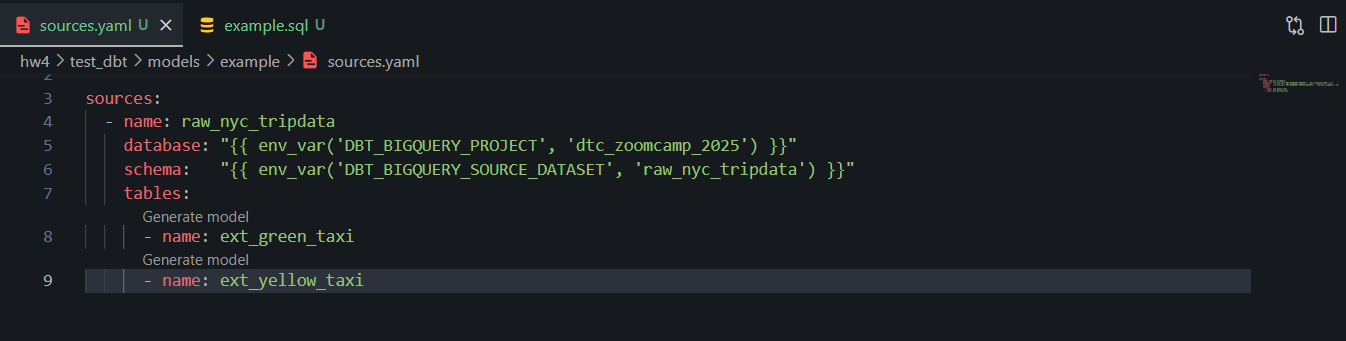

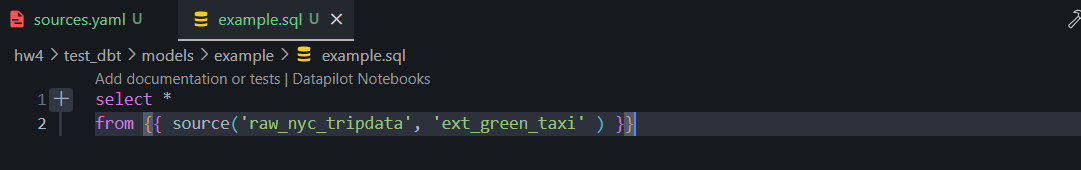

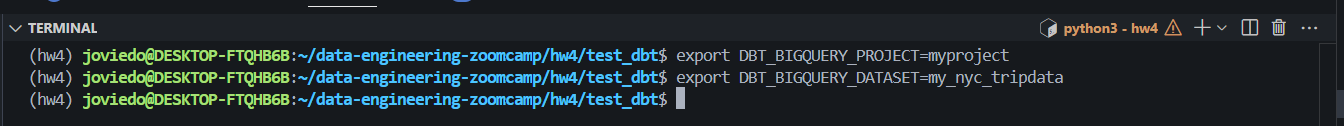

**Ejecutamos el siguiente comando**

```bash
dbt run
```

**Tabla compilada**

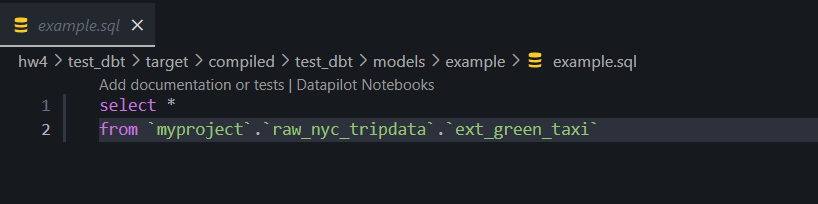

## Question 2: dbt Variables & Dynamic Models

**Realizamos los pasos mencionados en un proyecto de prueba**

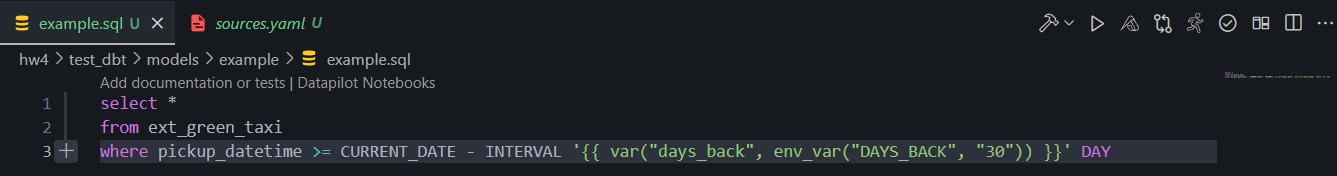

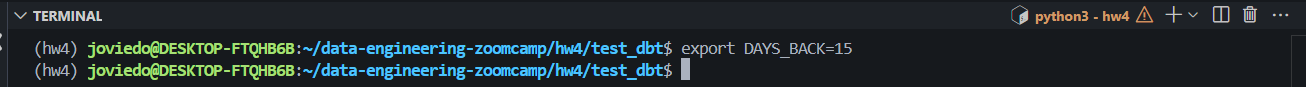

**Ejecutamos el siguiente comando**

```bash
dbt build --select example --vars '{'days_back':60}'
```

**Tabla compilada**

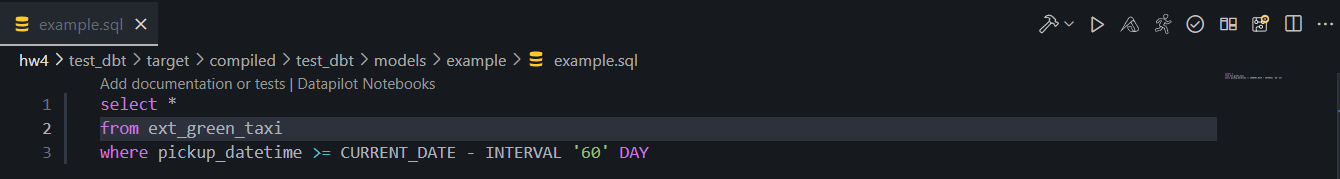

**Ejecutamos el siguiente comando**

```bash
dbt build --select example 
```

**Tabla compilada**

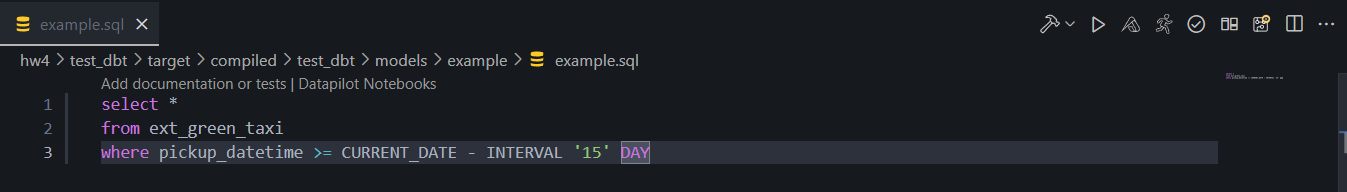

**Ejecutamos el siguiente comando**

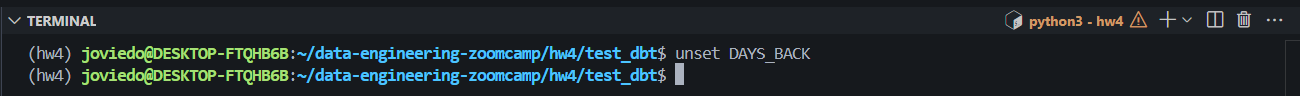

```bash
dbt build --select example 
```

**Tabla compilada**

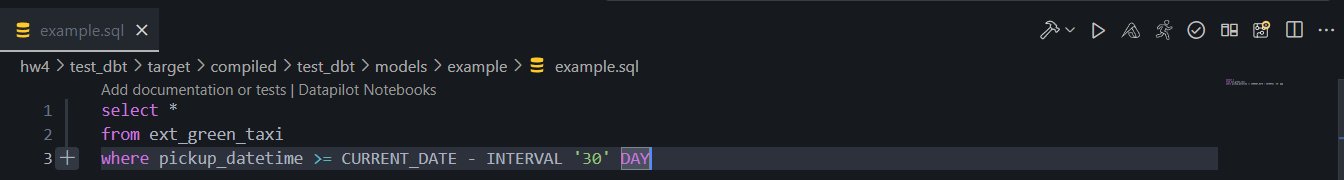

## Question 3: dbt Data Lineage and Execution

Teniendo en cuenta lo siguiente:

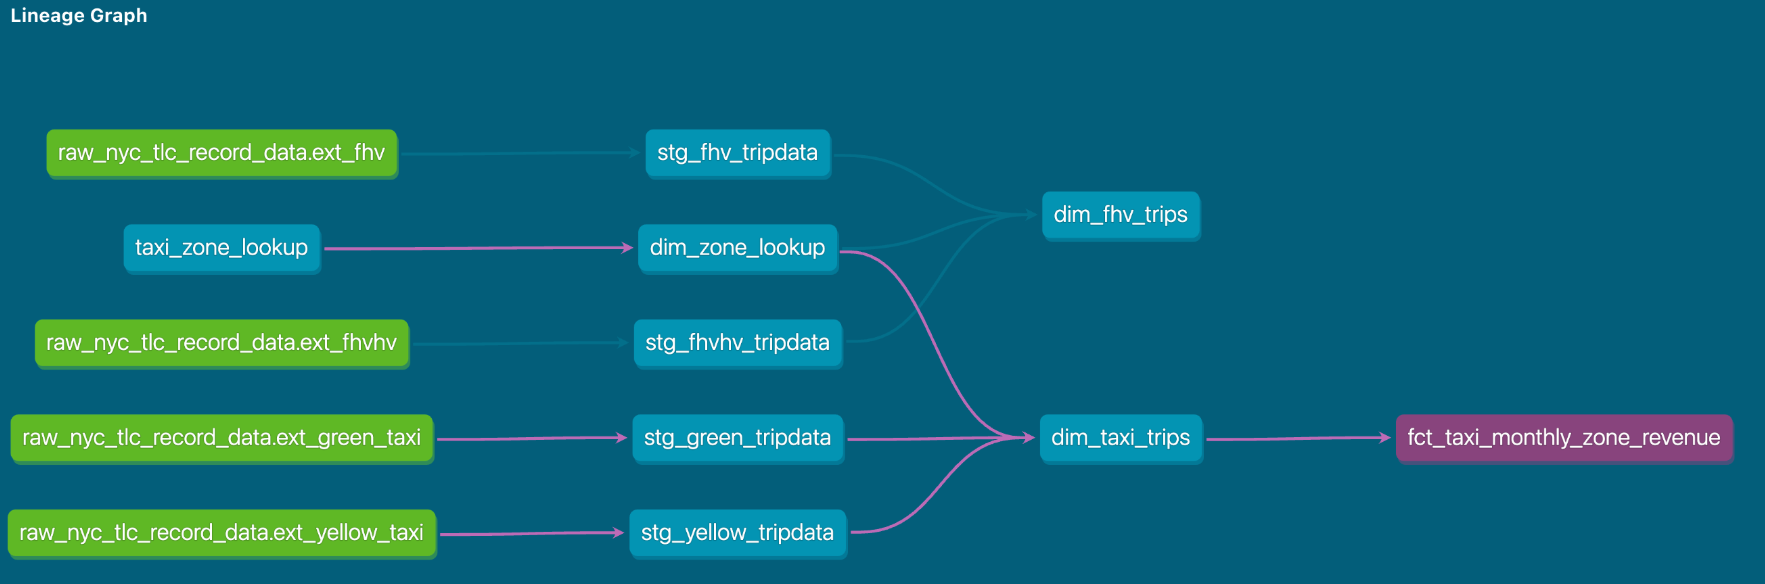

1. **`dbt run`**

   Esta opción ejecuta todos los modelos del proyecto, sin especificar un modelo en particular. Esto ejecutará todos los modelos en el proyecto, incluidos los de staging, dimensiones, hechos y cualquier otro modelo.

3. **`dbt run --select +models/core/dim_taxi_trips.sql+ --target prod`**

   Esta opción es un poco más específica. El uso del `+` en dbt indica que se seleccionan modelos y sus dependencias. En este caso, `+models/core/dim_taxi_trips.sql+` ejecutaría el modelo `dim_taxi_trips` y todos los modelos de los cuales depende.

4. **`dbt run --select +models/core/fct_taxi_monthly_zone_revenue.sql`**

   Esta opción ejecuta solo el modelo `fct_taxi_monthly_zone_revenue` y sus dependencias. Al seleccionar este modelo y sus dependencias, estarías materializando específicamente el modelo `fct_taxi_monthly_zone_revenue`.

5. **`dbt run --select +models/core/`**

   Este comando ejecuta todos los modelos dentro del directorio `core` y sus dependencias.

6. **`dbt run --select models/staging/+`**

   Esta opción ejecutará todos los modelos dentro del directorio `staging` y sus dependencias.


## Question 4: dbt Macros and Jinja

**Realizamos los pasos mencionados en un proyecto de prueba**

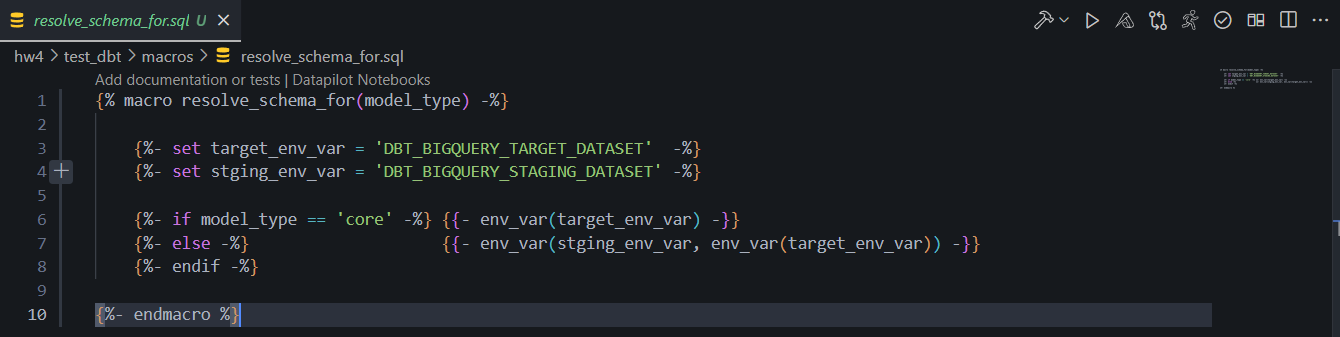

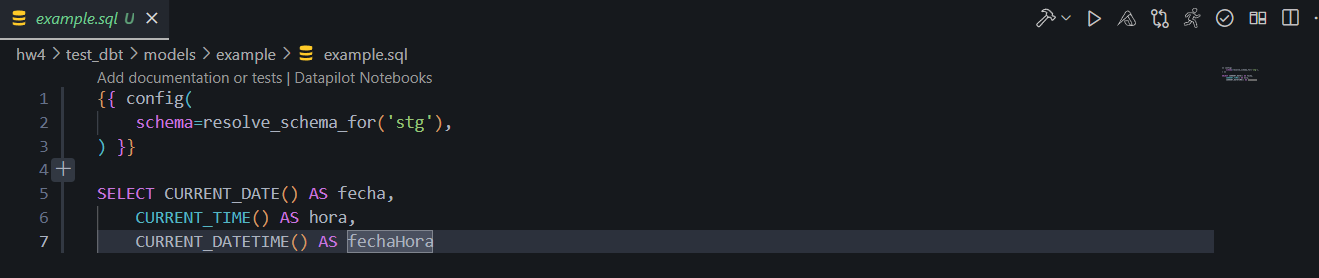

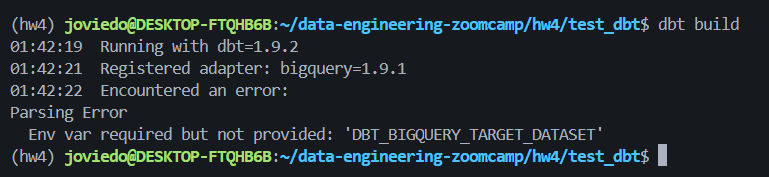

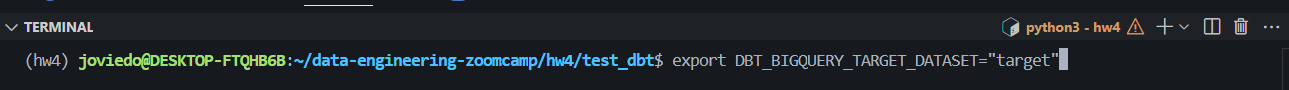

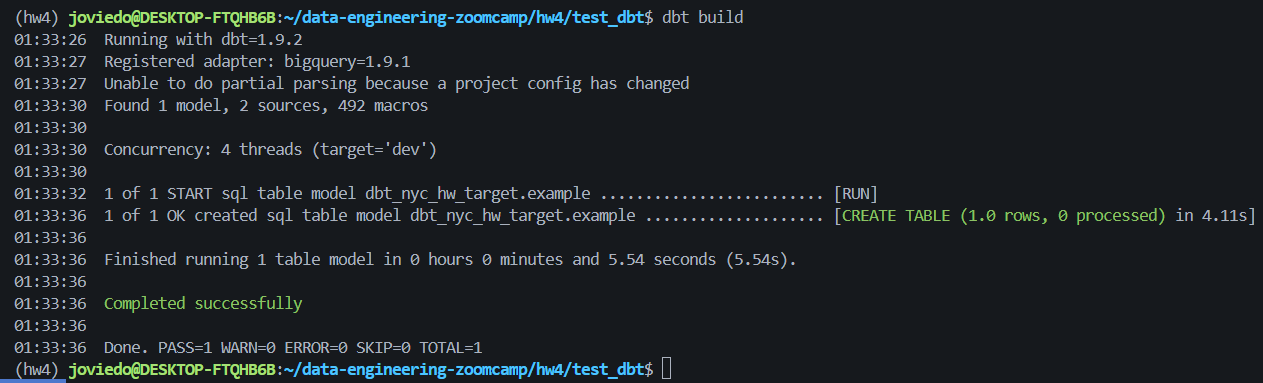

- ✔️ Setting a value for DBT_BIGQUERY_TARGET_DATASET env var is mandatory, or it'll fail to compile
- ❌ Setting a value for DBT_BIGQUERY_STAGING_DATASET env var is mandatory, or it'll fail to compile
- ✔️ When using core, it materializes in the dataset defined in DBT_BIGQUERY_TARGET_DATASET
- ✔️ When using stg, it materializes in the dataset defined in DBT_BIGQUERY_STAGING_DATASET, or defaults to DBT_BIGQUERY_TARGET_DATASET
- ✔️ When using staging, it materializes in the dataset defined in DBT_BIGQUERY_STAGING_DATASET, or defaults to DBT_BIGQUERY_TARGET_DATASET

## Question 5: Taxi Quarterly Revenue Growth

**Paso 1: modificamos el modelo `fct_taxi_trips`**

```sql
{{
    config(
        materialized='table'
    )
}}

with green_tripdata as (
    select *, 
        'Green' as service_type
    from {{ ref('stg_green_tripdata') }}
), 
yellow_tripdata as (
    select *, 
        'Yellow' as service_type
    from {{ ref('stg_yellow_tripdata') }}
), 
trips_unioned as (
    select * from green_tripdata
    union all 
    select * from yellow_tripdata
), 
dim_zones as (
    select * from {{ ref('dim_zones') }}
    where borough != 'Unknown'
)
select trips_unioned.tripid, 
    trips_unioned.vendorid, 
    trips_unioned.service_type,
    trips_unioned.ratecodeid, 
    trips_unioned.pickup_locationid, 
    pickup_zone.borough as pickup_borough, 
    pickup_zone.zone as pickup_zone, 
    trips_unioned.dropoff_locationid,
    dropoff_zone.borough as dropoff_borough, 
    dropoff_zone.zone as dropoff_zone,  
    trips_unioned.pickup_datetime, 
    trips_unioned.dropoff_datetime, 
    trips_unioned.store_and_fwd_flag, 
    trips_unioned.passenger_count, 
    trips_unioned.trip_distance, 
    trips_unioned.trip_type, 
    trips_unioned.fare_amount, 
    trips_unioned.extra, 
    trips_unioned.mta_tax, 
    trips_unioned.tip_amount, 
    trips_unioned.tolls_amount, 
    trips_unioned.ehail_fee, 
    trips_unioned.improvement_surcharge, 
    trips_unioned.total_amount, 
    trips_unioned.payment_type, 
    trips_unioned.payment_type_description,
    EXTRACT(YEAR from trips_unioned.pickup_datetime) as year,
    EXTRACT(QUARTER from trips_unioned.pickup_datetime) as quarter,
    EXTRACT(MONTH from trips_unioned.pickup_datetime) as month
from trips_unioned
inner join dim_zones as pickup_zone
on trips_unioned.pickup_locationid = pickup_zone.locationid
inner join dim_zones as dropoff_zone
on trips_unioned.dropoff_locationid = dropoff_zone.locationid
```

**Paso 2: creamos el modelo `fct_taxi_trips_quarterly_revenue`**

```sql
{{
    config(
        materialized='table'
    )
}}

WITH tripdata_revenue AS (
    SELECT 
        SUM(total_amount) AS revenue_quarter,
        service_type,
        year,
        quarter
    FROM {{ ref('fct_taxi_trips') }}
    WHERE year BETWEEN {{ var("year_start", 2000) }} AND {{ var("year_end", 2025) }}
    GROUP BY service_type, year, quarter
),
tripdata_revenue_quarter AS (
    SELECT 
        service_type,
        CONCAT(year, '/Q', quarter) AS year_quarter,
        revenue_quarter AS current_revenue,
        LAG(revenue_quarter, 4, 0) OVER(PARTITION BY service_type ORDER BY year, quarter) AS previous_revenue,
        (revenue_quarter - LAG(revenue_quarter, 4, 0) OVER(PARTITION BY service_type ORDER BY year, quarter)) * 100 AS diff_current_previous_revenue
    FROM tripdata_revenue
),
tripdata_revenue_quarter_growth AS (
    SELECT
        service_type,
        year_quarter,
        ROUND({{dbt_utils.safe_divide('diff_current_previous_revenue' , 'previous_revenue')}}, 2) as growth
    FROM tripdata_revenue_quarter
)
SELECT 
    service_type,
    year_quarter,
    CONCAT( FORMAT("%.2f", COALESCE(growth, 0)) , '%') AS growth
FROM tripdata_revenue_quarter_growth
ORDER BY service_type, year_quarter
-- dbt build --select <model_name> --vars '{ 'year_start': 2019, 'year_end': 2020 }'
```

**Paso 3: ejecutamos el siguiente comando para crear/recrear todos los modelos**

```bash
dbt build  --vars '{ 'year_start': 2019, 'year_end': 2020, 'is_test_run': False }'
```

En caso que solo se quiera reconstruir las tablas de los modelos modificados o creados se puede usar los siguientes comandos

```bash
dbt build --select fct_taxi_trips

dbt build --select fct_taxi_trips_quarterly_revenue --vars '{ 'year_start': 2019, 'year_end': 2020 }'
```

**Podemos ver los resultados en BigQuery**

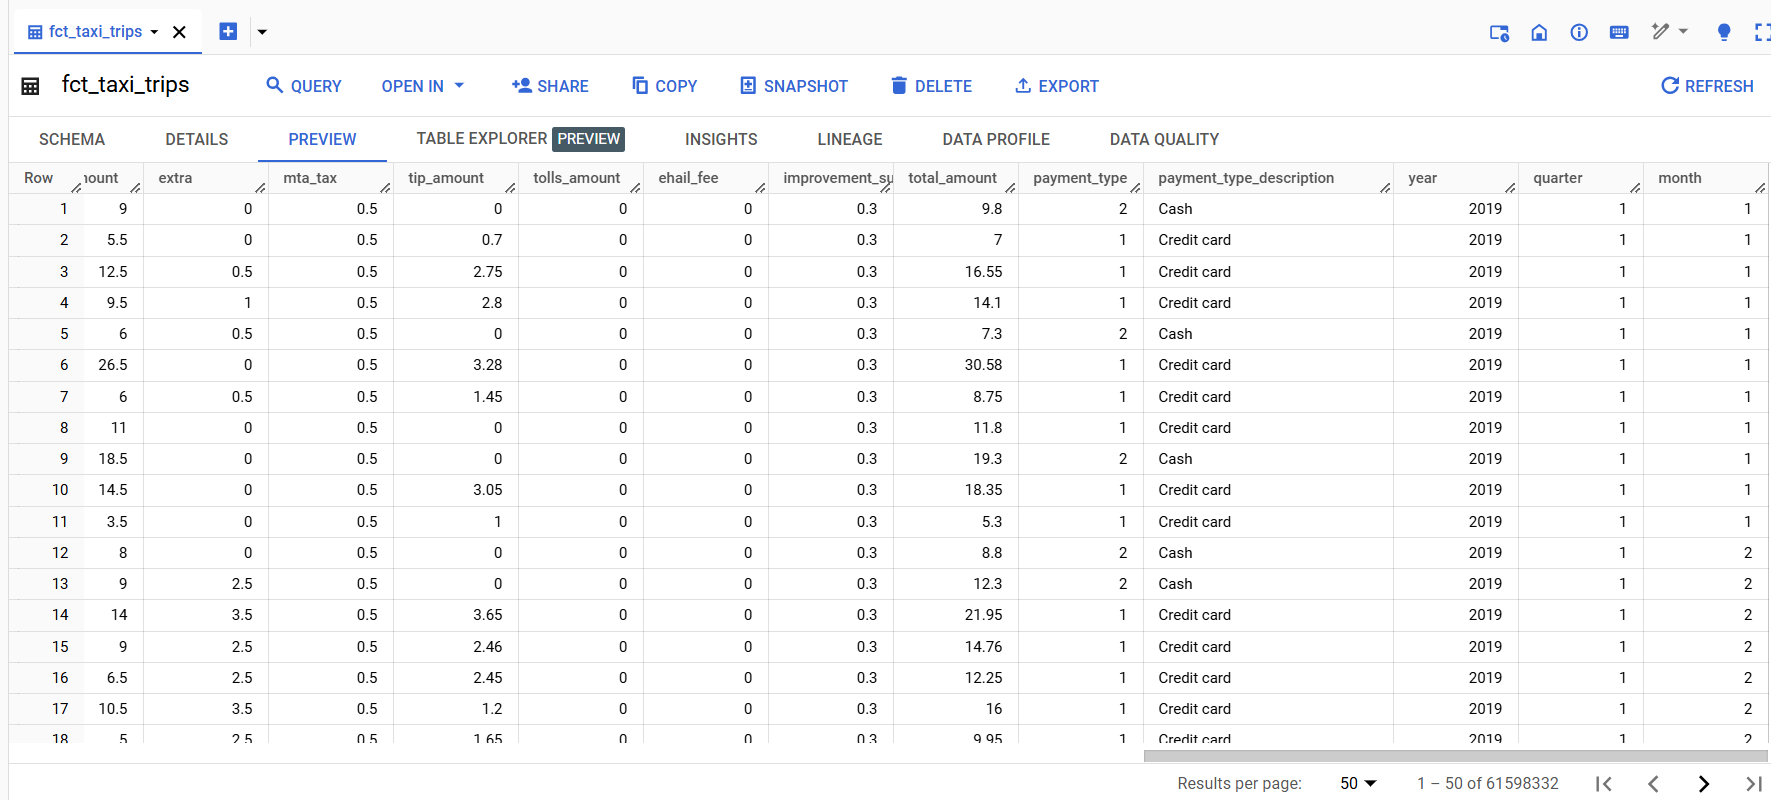

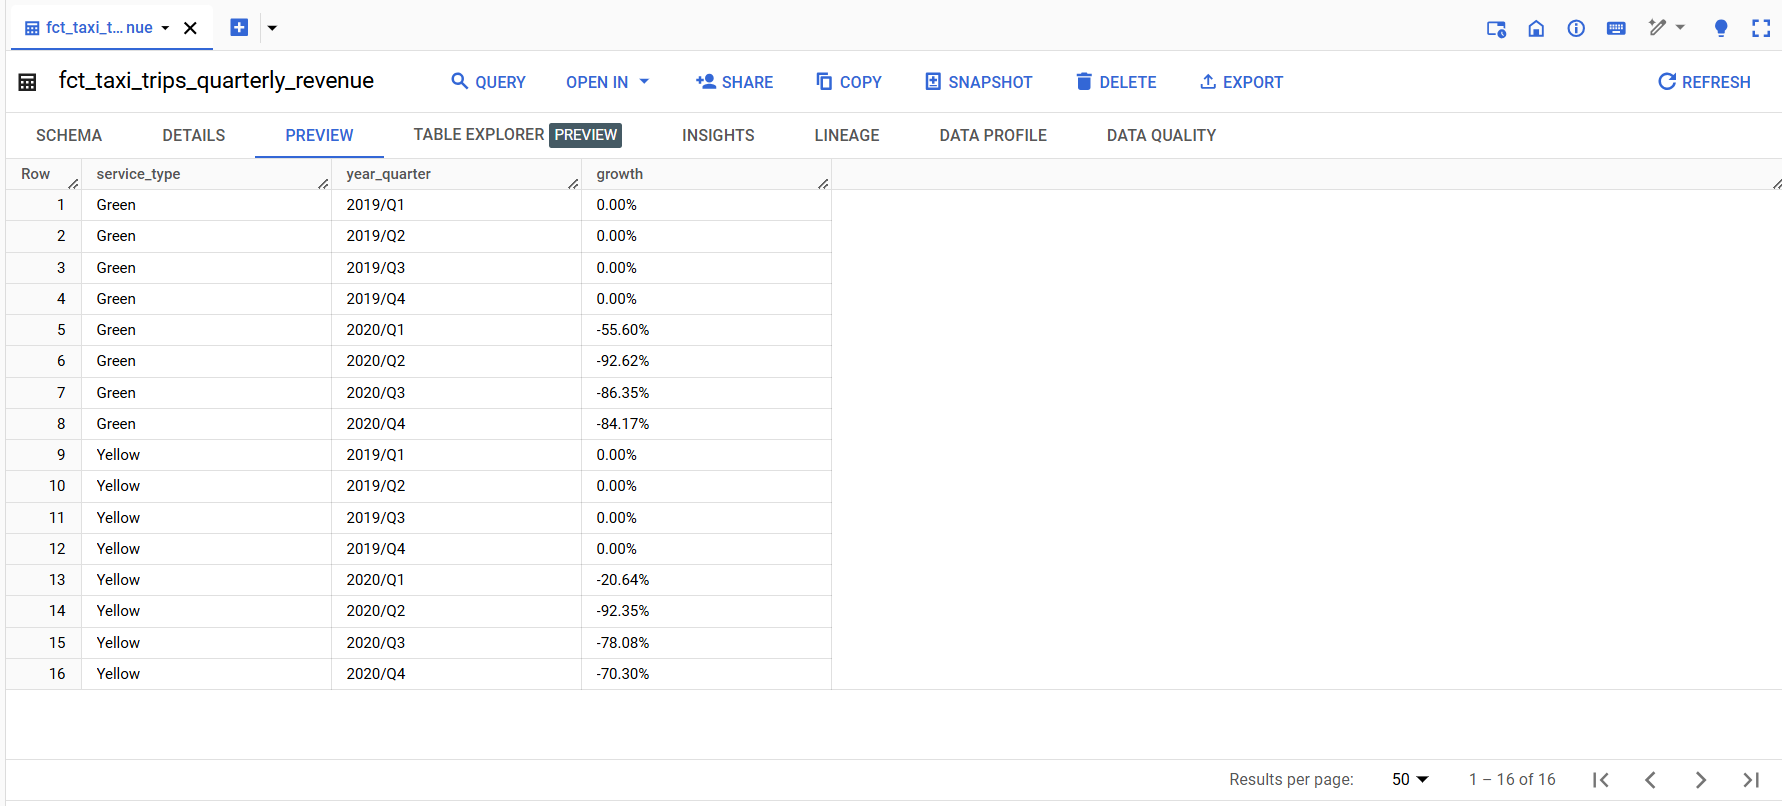


## Question 6: P97/P95/P90 Taxi Monthly Fare

**Paso 1: creamos el modelo `fct_taxi_trips_monthly_fare_p95`**

```sql
{{
    config(
        materialized='table'
    )
}}

WITH tripdata_filter AS (
    SELECT 
        service_type,
        year,
        month,
        fare_amount
    FROM {{ ref('fct_taxi_trips') }}
    WHERE fare_amount > 0
    AND trip_distance > 0
    AND lower(payment_type_description) in (lower('Cash'), lower('Credit Card'))
    AND year BETWEEN {{ var("year_start", 2000) }} AND {{ var("year_end", 2025) }}
),
tripdata_percentile AS (
    SELECT DISTINCT
        service_type,
        year,
        month,
        PERCENTILE_CONT(fare_amount, 0.97) OVER (PARTITION BY service_type, year, month) AS p97_fare_amount,
        PERCENTILE_CONT(fare_amount, 0.95) OVER (PARTITION BY service_type, year, month) AS p95_fare_amount,
        PERCENTILE_CONT(fare_amount, 0.90) OVER (PARTITION BY service_type, year, month) AS p90_fare_amount
    FROM tripdata_filter
)
SELECT 
    service_type,
    year,
    month,
    FORMAT("%.2f",ROUND(p90_fare_amount, 1)) AS p90_fare_amount,
    FORMAT("%.2f",ROUND(p95_fare_amount, 1)) AS p95_fare_amount,
    FORMAT("%.2f",ROUND(p97_fare_amount, 1)) AS p97_fare_amount
FROM tripdata_percentile
ORDER BY year, month, service_type
-- dbt build --select <model_name> --vars '{ 'year_start': 2019, 'year_end': 2020 }'
```

**Paso 2: ejecutamos el siguiente comando para crear el nuevo modelo**

```bash
dbt build --select fct_taxi_trips_monthly_fare_p95 --vars '{ 'year_start': 2019, 'year_end': 2020 }'
```

**Podemos ver los resultados en BigQuery**

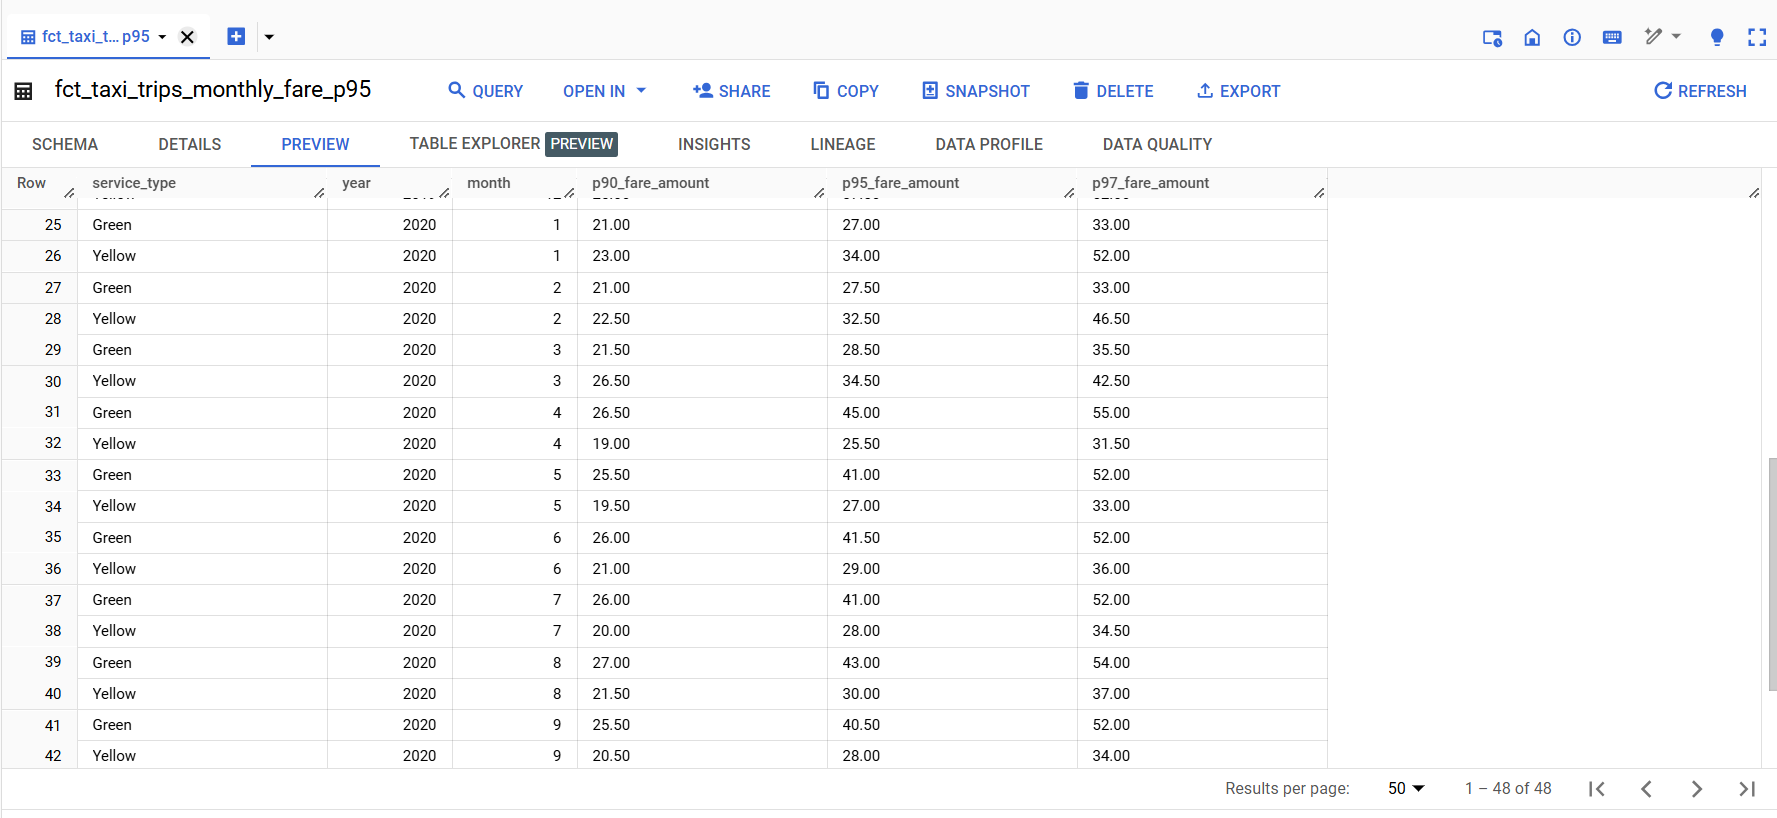

## Question 7: Top #Nth longest P90 travel time Location for FHV

**Paso 1: creamos el modelo `dim_fhv_trips`**

```sql
{{
    config(
        materialized='table'
    )
}}

WITH fhv_tripdata AS (
    SELECT 
        *
    FROM {{ ref('stg_fhv_tripdata') }}
), 
dim_zones AS (
    SELECT 
        * 
    FROM {{ ref('dim_zones') }}
    where borough != 'Unknown'
)
SELECT
    fhv_tripdata.tripid,
    fhv_tripdata.dispatching_base_num,
    fhv_tripdata.affiliated_base_number,
    fhv_tripdata.pickup_datetime,
    fhv_tripdata.dropoff_datetime,
    fhv_tripdata.pickup_locationid,
    pickup_zone.borough AS pickup_borough, 
    pickup_zone.zone AS pickup_zone, 
    fhv_tripdata.dropoff_locationid,
    dropoff_zone.borough AS dropoff_borough, 
    dropoff_zone.zone AS dropoff_zone,  
    fhv_tripdata.sr_flag,
    EXTRACT(YEAR from fhv_tripdata.pickup_datetime) AS year,
    EXTRACT(MONTH from fhv_tripdata.pickup_datetime) AS month
FROM fhv_tripdata
INNER JOIN dim_zones AS pickup_zone
ON fhv_tripdata.pickup_locationid = pickup_zone.locationid
INNER JOIN dim_zones AS dropoff_zone
ON fhv_tripdata.dropoff_locationid = dropoff_zone.locationid
```

**Paso 2: creamos el modelo `fct_fhv_monthly_zone_traveltime_p90`**

```sql
{{
    config(
        materialized='table'
    )
}}

WITH fhv_tripdata AS (
    SELECT
        *,
        TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) AS trip_duration
    FROM {{ ref('dim_fhv_trips') }}
), 
tripdata_percentile AS (
    SELECT 
        *,
        PERCENTILE_CONT(trip_duration, 0.90) OVER (PARTITION BY year, month, pickup_locationid, dropoff_locationid) AS p90_trip_duration,
    FROM fhv_tripdata
),
ranked_trips AS (
    SELECT 
        year,
        month,
        pickup_zone,
        dropoff_zone,
        p90_trip_duration,
        DENSE_RANK() OVER (PARTITION BY pickup_zone ORDER BY p90_trip_duration DESC) AS p90_rank
    FROM tripdata_percentile
    WHERE year = {{ var("year", 2000) }}
    AND month = {{ var("month", 1) }}
    AND lower(pickup_zone) IN {{ lower_list( var('list_zone_pickup', []) ) }} 
)
SELECT DISTINCT
    year,
    month,
    pickup_zone,
    dropoff_zone,
    FORMAT("%.2f",ROUND(p90_trip_duration, 2)) AS p90_trip_duration,
    p90_rank
FROM ranked_trips
WHERE p90_rank = {{ var("rank", 1) }} 
ORDER BY pickup_zone
-- dbt build --select <model_name> --vars '{ 'year': 2019, 'month': 11, 'rank': 2, list_zone_pickup: ['Newark Airport', 'SoHo', 'Yorkville East'] }'
```

**Paso 3: ejecutamos los siguientes comandos para crear los nuevos modelos**

```bash
dbt build --select dim_fhv_trips

dbt build --select fct_fhv_monthly_zone_traveltime_p90 --vars '{ 'year': 2019, 'month': 11, 'rank': 2, list_zone_pickup: ['Newark Airport', 'SoHo', 'Yorkville East'] }'
```

**Podemos ver los resultados en BigQuery**

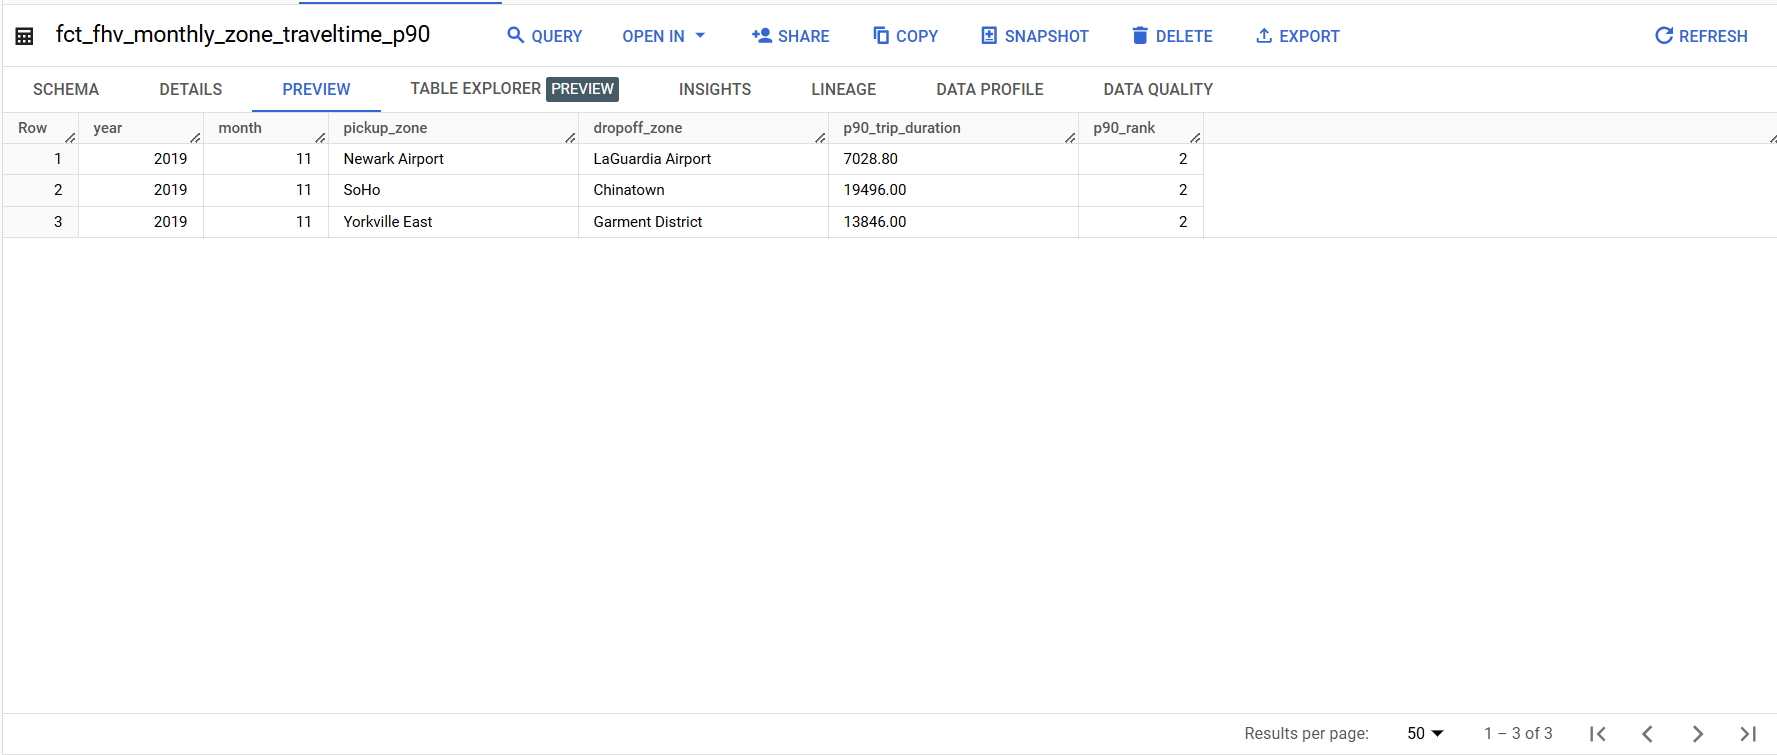